# GPTQ
Based on YSDA NLP [Homework](https://github.com/yandexdataschool/nlp_course/tree/2024/week10_efficiency) authored by a lecturer Andrei Parfenov completed by Kamil Mardanshin.

# Installing the Dependencies

In [ ]:
#%%capture
%pip install torch==2.4.0
%pip install transformers==4.35.0
%pip install sentencepiece==0.1.99
%pip install datasets==2.14.6
%pip install accelerate==0.24.1
%pip install Ninja==1.11.1.1

### Imports

In [ ]:
import os
import math
import random
from tqdm.notebook import tqdm, trange
from typing import Mapping
import matplotlib.pyplot as plt

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

import transformers
from transformers.models.llama.modeling_llama import LlamaDecoderLayer, LlamaForCausalLM
from transformers.models.llama.configuration_llama import LlamaConfig
from transformers import AutoTokenizer
from datasets import load_dataset

# Quantizing Matrices Row-Wise

### Basic Quantization

**Mapping the values to the allowed range**

Quantization is the process of mapping input values from a large set to output values in a smaller set. For instance, if we consider 4-bit
quantization, our values are represented by $4$ bits, meaning we can represent values between 0 and $2^4-1=15$.

 * To produce the quantized representation, we need to be able to map the matrix values to and from this range.
 * For reasons that become important later, we will perform this mapping independently for each matrix row.
 * We will parametrize the mapping like this: $out = \frac{in}{scale} + zero$, where $scale$ and $zero$ are row-wise constants.
 * For a matrix of size `(m, k)` ($m$ rows, $k$ columns) we will aggregate those parameters into two vectors `scale` and `zero` of size `(m, 1)`.

In [3]:
def get_scale_and_zero(x: Tensor, max_abs: float) -> tuple[Tensor, Tensor]:
    """ Given a tensor x of shape (m, k) and max_abs > 0 produce tensors scale and zero of shape (m, 1)
        such that 0 < x / scale + zero < max_abs"""
    xmin = x.min(dim=-1, keepdim=True)[0]
    xmax = x.max(dim=-1, keepdim=True)[0]

    scale = (xmax - xmin) / max_abs
    scale[scale.abs() < 1e-5] = 1.
    zero = -xmin/scale

    return scale, zero

**Quantization**

Having mapped the values into the allowed range, we can simply round them to obtain the quantized matrix.

In [4]:
def quantize(x: Tensor, scale: Tensor, zero: Tensor, bits: int) -> Tensor:
    """Quantizes a tensor
    Args:
        x (Tensor): tensor to quantize
        scale (Tensor): values interval mapping scale
        zero (Tensor): values interval mapping zero
        bits (int): number of bits to quantize to

    Returns:
        Tensor: quantized tensor in uint8
    """
    quantized_x = torch.clamp(x / scale + zero, min=0, max=2**bits - 1) + 0.5

    return quantized_x.to(torch.uint8)


def dequantize(quantized_x: Tensor, scale: Tensor, zero: Tensor) -> Tensor:
    """Dequantize a tensor
    Args:
        quantized_x (Tensor): quantized tensor in uint8
        scale (Tensor): values interval mapping scale
        zero (Tensor): values interval mapping zero

    Returns:
        Tensor: dequantized tensor
    """
    return (quantized_x - zero) * scale


def measure_and_quantize(x: Tensor, bits: float) -> tuple[Tensor, Tensor, Tensor]:
    """Determine the values interval mapping parameters and quantize a tensor
    Args:
        x (Tensor): tensor to quantize
        bits (float): number of bits to quantize to

    Returns:
        tuple[Tensor, Tensor, Tensor]: quantized tensor, scale, zero
    """
    scale, zero = get_scale_and_zero(x, 2 ** bits - 1)
    x_quantized = quantize(x, scale, zero, bits)

    return x_quantized, scale, zero


**Using the quantized matrix**

To actually use the matrix, we'll have to map it's values back into their original form.

In [5]:
class QuantizedLinear(nn.Module):
    def __init__(self, quantized_weight, scale, zero, bias):
        super().__init__()
        self.quantized_weight = nn.Parameter(quantized_weight, requires_grad=False)
        self.scale = nn.Parameter(scale, requires_grad=False)
        self.zero = nn.Parameter(zero, requires_grad=False)
        self.bias = nn.Parameter(bias.data.clone().detach()) if bias is not None else None

    def forward(self, input):
        return F.linear(input, dequantize(self.quantized_weight, self.scale, self.zero), self.bias)


This class will be used as a replacement for `nn.Linear`. It holds the quantized weight and only dequantizes it during it's forward passes.

# LLM Quantization

### Preparations

Run all the cells in this subsection to download and prepare the model and the data

**Downloading the model**

Run the code below to download the model checkpoint.

In [14]:
!mkdir model

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


mkdir: cannot create directory 'model': File exists


In [6]:
from huggingface_hub import snapshot_download

LLAMA_REPO = "Enoch/llama-7b-hf"
snapshot_download(repo_id=LLAMA_REPO, local_dir="./model")


**Dispatching the model**

To properly quantize the model we'll need two functions.
 1. `initialize_layerless_llama` creates a llama model without any layers, but correct weights otherwise
 2. `load_and_dispatch_a_layer` loads a layer inserts it into the model after the last layer

In [7]:
# Disable fancy model initialization since we'll override those values anyway
def skip(*args, **kwargs):
    pass
torch.nn.init.kaiming_uniform_ = skip
torch.nn.init.uniform_ = skip
torch.nn.init.normal_ = skip


def initialize_layerless_llama(checkpoint_path):
    config = LlamaConfig.from_pretrained(LLAMA_REPO)
    config.num_hidden_layers=0

    model = LlamaForCausalLM(config)
    model.load_state_dict(torch.load(os.path.join(checkpoint_path, "pytorch_model-00033-of-00033.bin")))
    model.seqlen = 2048
    model.config.use_cache = False

    return model.to(torch.float16)


def load_and_dispatch_a_layer(layer_idx, checkpoint_path, model: LlamaForCausalLM):
    if checkpoint_path == "TEST":
        linear = nn.Linear(16, 16)
        linear.weight.data = torch.arange(16 * 16).reshape(16, 16).float()
        model.model.layers.append(nn.ModuleDict({"submodule": linear}))
        return

    config = transformers.AutoConfig.from_pretrained(LLAMA_REPO)

    layer = LlamaDecoderLayer(config)
    layer_state_dict = torch.load(os.path.join(checkpoint_path, f"pytorch_model-{layer_idx + 1:05}-of-00033.bin"))
    layer_state_dict = {name[len(f"model.layers.{layer_idx}."):]: tensor for name, tensor in layer_state_dict.items()}
    layer.load_state_dict(layer_state_dict, strict=False)
    del layer_state_dict

    model.model.layers.append(layer.to(torch.float16))

Calling `initialize_layerless_llama` and then calling `load_and_dispatch_a_layer` for each layer in order would fully load the model, but we'll also quantize the layes as we go.

### RTN Quantization for LLaMA

**Auxiliary functions:**
 * `find_layers` takes a module and returns a dictionary containing all of it's *Linear* submodules with their path-names as the keys.
 * `replace_submodule` takes a module, a path-name and a submodule and replaces the module's submodule at path-name with the new submodule.

In [8]:
def find_layers(module: nn.Module, name='') -> dict[str, nn.Module]:
    if type(module) == nn.Linear:
        return {name: module}
    res = {}
    for name1, child in module.named_children():
        res.update(find_layers(
            child, name=name + '.' + name1 if name != '' else name1
        ))
    return res


def replace_submodule(module, submodule_path, new_submodule):
    submodule_names = submodule_path.split(".")
    for submodule in submodule_names[:-1]:
        module = getattr(module, submodule)
    setattr(module, submodule_names[-1], new_submodule)

**Load-Quantize cycle**

In [9]:
@torch.no_grad()
def llama_rtn(checkpoint_path: os.PathLike, model: LlamaForCausalLM, bits: int):
    """Loads LLaMA layers one by one and quantizes them with RTN
    Args:
        checkpoint_path (os.PathLike): folder containing LLaMA weights
        model (LlamaForCausalLM): model to dispatch layers into
        bits (int): number of bits to quantize to
    """
    # Load and quantize all the layers
    layers = model.model.layers
    assert len(layers) == 0
    for i in trange(32):
        load_and_dispatch_a_layer(i, checkpoint_path, model)
        layer = layers[i].cuda()

        linear_submodules = find_layers(layer)
        # Quantize the linear layers and replace the original ones with them
        for name, linear in linear_submodules.items():
            qweight, scale, zero = measure_and_quantize(linear.weight, bits)
            replace_submodule(layer, name, QuantizedLinear(qweight, scale, zero, linear.bias))

        layers[i] = layer.cpu()
        torch.cuda.empty_cache()


### Testing the Quantized Model

Now we have everything we need to quantize the _LLaMA-7B_ model to 4 bits. Let us do that.

In [10]:
MODEL = "./model/"
SEED = 0
BITS = 4

In [11]:
tokenizer = AutoTokenizer.from_pretrained(LLAMA_REPO, use_fast=False)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [11]:
model = initialize_layerless_llama(MODEL)
llama_rtn(MODEL, model, BITS)
model = model.cuda()

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [13]:
questions = [
    "What is the capital of France?",
    "Can you explain the Pythagorean theorem?",
    "What is photosynthesis?",
    "Give me a summary of 'Romeo and Juliet'",
    "How far is the moon from the Earth?",
    "What is a haiku?",
]
answers = []

for question in tqdm(questions):
    tokenized_input = tokenizer(
        f"QUESTION: {question}\n ANSWER:",
        return_tensors="pt"
    )
    with torch.no_grad():
        output = model.generate(
            tokenized_input["input_ids"].cuda(),
            max_length=50, num_beams=3, early_stopping=True,
        )[0]
    answer = tokenizer.decode(output, skip_special_tokens=True)
    answers.append(answer[:answer.find(".")] + ".")


  0%|          | 0/6 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


In [15]:
print(*answers, sep="\n\n")

QUESTION: What is the capital of France?
 ANSWER: Paris
 QUESTION: What is the capital of Germany?
 ANSWER: Berlin
 QUESTION: What is the capita.

QUESTION: Can you explain the Pythagorean theorem?
 ANSWER: The Pythagorean theorem states that in a right triangle, the square of the side opposite the right angle is equal to th.

QUESTION: What is photosynthesis?
 ANSWER: Photosynthesis is the process by which plants use the energy of sunlight to convert carbon dioxide and water into carbohydrates.

QUESTION: Give me a summary of 'Romeo and Juliet'
 ANSWER: Romeo and Juliet is a tragedy written by William Shakespeare about two young star-crossed lovers, whos.

QUESTION: How far is the moon from the Earth?
 ANSWER: About 240,000 miles.

QUESTION: What is a haiku?
 ANSWER: A haiku is a form of Japanese poetry that consists of three unrhymed lines of 5, 7, and 5 syllables.


In [16]:
model = model.cpu()
torch.cuda.empty_cache()

### Evaluating the model

Before we start quantizing the model itself, let us create a way to evaluate it's performance.


**Downloading the data**

As a metric of the models' performance, we'll use it's PPL on the [wikitext2](https://paperswithcode.com/dataset/wikitext-2) dataset. Let us download and tokenize it. We'll need two subsets of it:
 * Test set of size ... to evaluate the models.
 * A train subset of size ... that we'll use later for GPTQ.

In [12]:
SEED = 0

def get_wikitext2(seed, seqlen, nsamples=128):
    traindata = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train')
    testdata = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')

    tokenizer = AutoTokenizer.from_pretrained(LLAMA_REPO, use_fast=False)

    train_input_ids = tokenizer("\n\n".join(traindata['text']), return_tensors='pt').input_ids
    random.seed(seed)
    train_batch = []
    for _ in range(nsamples):
        i = random.randint(0, train_input_ids.shape[1] - seqlen - 1)
        j = i + seqlen
        inp = train_input_ids[:, i:j]
        tar = inp.clone()
        tar[:, :-1] = -100
        train_batch.append(inp[0])

    test_input_ids = tokenizer("\n\n".join(testdata['text']), return_tensors='pt').input_ids
    test_input_ids = test_input_ids[:, :(test_input_ids.shape[1] // seqlen) *  seqlen]
    test_input_ids = test_input_ids.reshape(test_input_ids.shape[1] // seqlen, seqlen)

    return torch.stack(train_batch), test_input_ids

train_batch, test_input_ids = get_wikitext2(SEED, 2048)

**Model offloading**

We want to evaluate the model's performance on a large dataset. The model barely fits on the *GPU*, and we'll have to infer in on long text sequences. We don't have enought *VRAM* to do that.

Instead, we'll keep most of the model in *RAM*, only transferring the layers to *GPU* as we go through them one by one, and putting them back when we're done.

**Obtaining the first layer inputs**

To start iterating over the layers, we'll first have to obtain the fist layer inputs. We use the function below to do it.

In [13]:
!wget -nc https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week10_efficiency/utils.py --no-check-certificate

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


File 'utils.py' already there; not retrieving.



In [14]:
from utils import get_first_layer_inputs

In [15]:
class TestModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.ModuleDict({"layers": nn.ModuleList([])})

    def forward(self, inp):
        self.model.layers[0](2 * inp, attention_mask="Some Mask", position_ids="Some Ids")

**Forward passing layer-by-layer**

In [16]:
def forward_pass_layer(layer: nn.Module, inps: torch.Tensor, outs: torch.Tensor, attention_mask: Tensor, position_ids: Tensor):
    """Forward pass inps through the layer ONE INP AT A TIME saving the outputs into the corresponding elements of outs"""
    for j in range(inps.shape[0]):
        outs[j] = layer(inps[j].unsqueeze(0), attention_mask=attention_mask, position_ids=position_ids)[0]


def get_batch_nll(model: nn.Module, batch: Tensor):
    # Collect the first layer inputs, put them on .cuda()
    inps, attention_mask, position_ids = get_first_layer_inputs(model, batch)
    inps = inps.cuda()
    attention_mask = attention_mask.cuda()
    position_ids = position_ids.cuda()

    # Create a buffer for layer outputs
    outs = torch.zeros_like(inps)

    # Forward pass through the layers
    layers = model.model.layers
    assert len(layers) == 32
    for i in trange(32, leave=False):
        layer = layers[i].cuda() # Take a layer and put in on .cuda()

        forward_pass_layer(layer, inps, outs, attention_mask, position_ids) # Forward pass a layer
        inps, outs = outs, inps # Prepare the inputs and the output buffer for the next layer. Reuse the existing buffers

        layers[i] = layer.cpu() # Put layer back on .cpu()
        del layer
        torch.cuda.empty_cache()


    # Calculate NLL
    nll = 0
    model.model.norm = model.model.norm.cuda()
    model.lm_head = model.lm_head.cuda()
    for i in range(inps.shape[0]):
        lm_logits = model.lm_head(model.model.norm(inps[i].unsqueeze(0)))
        labels = batch[i]
        # Calculate the language modeling Negative Log Likelyhood
        shift_logits = lm_logits[:, :-1, :]
        shift_labels = labels[1:]
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1).cuda())
        nll += float(loss) * model.seqlen
    model.model.norm = model.model.norm.cpu()
    model.lm_head = model.lm_head.cpu()
    return nll


@torch.no_grad()
def llama_eval(model, test_input_ids):
    print('Evaluating ...')

    total_nll = 0
    for batch in tqdm(torch.tensor_split(test_input_ids, 4)):
        total_nll += get_batch_nll(model, batch)

    # Calculate PPL
    ppl = math.exp(total_nll / test_input_ids.numel())
    print(f"PPL: {ppl}")
    return ppl

**Calculating PPL**

We've already loaded and quantized the model. All that's left is to evaluate it.

In [22]:
rtn_ppl = llama_eval(model, test_input_ids)

Evaluating ...


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

PPL: 6.44185473110758


Unfortunately, to check the performance of the original model (unquantized, full precision) we need more than 16GB GPU and 28GB RAM (the run crushes due to memory limit)

In [22]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(MODEL, torch_dtype=torch.float16)
model.seqlen = 2048

llama_eval(model, test_input_ids)

Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=map

Evaluating ...


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

PPL: 5.677062976052216


5.677062976052216

In [26]:
del model
torch.cuda.empty_cache()

### GPTQ

GPTQ is the State Of The Art quantization algorithm for post-training DL model quantization. It works by sequentially quantizing the model's linear layer weights.

Although in outputs results similar to what one would get with Round To Nearest quantization, it makes a key observations to boost it's end performance:
 * It is layer input aware (also referred to as "1-Shot" method), meaning int optimizes the quantized matrix to show best performance on inputs typically encountered in that layer.
More formally, the problem can be formulated as:
$$
W_q = argmin_{\widehat{W}}\|XW^T - X\widehat{W}^T\|_2^2
$$
, where
 * $X$ is the input matrix of shape `(..., IN)`.
 * $XW^T$ is the unquantized output of shape `(..., OUT)`. We think of the norm above as taking a sum over those (...) dimensions.
 * $W$ is the unquantized weight of shape `(OUT, IN)`.
 * $\widehat{W}$ is the quantized weight taken from some quantization grid.

One can notice that the expression above is independent with regard to the rows of $W$ and $\widehat{W}$, meaning we can solve it for each row in parallel. This is the reason why we're working with row-wise quantization in the first place. Notice that the quantization grid only depends on min/max values withing the row and not the quantization process, so we can think of it as fixed.

and the dimension of the optimization problem is `IN`, which is too much to solve exactly. The algorithm proposes to solve it iteratively.

Less us consider a vector of full precision weights $F$ and corresponding sent of inputs $X_F$. The corresponding objective is quadratic with Hessian
$$
H_F = 2X_F^TX_F^.
$$
The algorithm can be described like this:
 * Do the following steps until $F$ is fully quantized:
    1. Given the next index to quantize $i$, and corresponding unquantized element $F_i$.
    2. Quantize the coordinate by prjecting in onto the quantization grid $Q_i = quant(F_i)$.
    3. Update all of the remaining weights
    \begin{gather*}
    F_: = F_: - \frac{F_i - quant(F_i)}{\left[H_F^{-1}\right]_{ii}}\cdot\left[H_F^{-1}\right]_{i,:}
    \end{gather*}
    4. Exclude $i$ from $F$.

It uses the inverse Hessian to slightly tune the remaining unquantized weights to mitigate the quantization error.

As for how $i$ is chosen, an observation was made that iterating over indices in order of **decreasing diagonal Hessian elements** provides the best performance.

There are a few more ideas that make this algorithm much faster:
 1. We can represent the order of quantization (selection of $i$) by permuting the row in advance, and then iterating over the row element in order.
 $$
   F_{i:} = F_{i:} - \frac{F_{i} - quant(F_{i})}{\left[H_F^{-1}\right]_{ii}}\cdot\left[H_F^{-1}\right]_{i,i:}
 $$
 2. The problem is row-wise independent, meaning that we use the same permutation each row and perform those operations in a vector fashion for all the rows at the same time.
 $$
   F_{:,i:} = F_{:,i:} - \frac{F_{:,i} - quant(F_{:,i})}{\left[H_F^{-1}\right]_{ii}}\cdot\left[H_F^{-1}\right]_{i,i:}
 $$
 3. We don't actually need to recompute the inverse Hessian. At $i$-th step we only need its $t$-th row, and we can use fancy math to precompute the matrix containing all of those rows in advance.
 $$
  H^{-1} = Cholesky(H^{-1})^T    
 $$

 4. We don't need to tune all the remaining unquantized values right away. We can only apply the updates for the closest elements right away and accumulate all the other updates to apply them only once in a while.

    We'll do this in block of fixed size, applying the updates inside of those blocks and updating the weights outside only when we're done with the block. To accumulate those updates, we'll collect the scaled quantization error
    $$
      Err_{:,i} =\frac{F_{:,i} - quant(F_{:,i})}{\left[H_F^{-1}\right]_{ii}}\text{ for all }i\text{ in block}.
    $$

**GPTQ within blocks**

Implement GPTQ within the block. Iterate over the columns in ordered vector fashion, quantizing them one by one and updating all the remaining colums within the block.

Return the quantized weight as well as the matrix of quantization errors that we'll need to tune the unquantized weights outside of the block.

In [17]:
@torch.no_grad()
def gptq_block(block_weight: Tensor, block_hessian_inverse: Tensor, scale: Tensor, zero: Tensor, bits: int) -> tuple[Tensor, Tensor]:
    """Perform GPTQ within block
    Args:
        block_weight (Tensor): weight to quantize of shape (OUT, BLOCK_SIZE)
        block_hessian_inverse (Tensor): Cholesky inverse Hessian. Upper triangular of shape (BLOCK_SIZE, BLOCK_SIZE)
        scale (Tensor): row-wise quantization constats of shape (OUT, 1)
        zero (Tensor): row-wise quantization constats of shape (OUT, 1)
        bits (int): number of bits to quantize() to

    Returns:
        tuple[Tensor, Tensor]: quantized weight and scaled quantization error
    """
    block_weight = block_weight.clone()
    quantized_block_weight = torch.zeros(block_weight.shape, dtype=torch.uint8, device=block_weight.device)
    scaled_block_error = torch.zeros_like(block_weight)

    # Interate over the block's columns
    for i in range(block_weight.shape[1]):
        # Get the column and the corresponding inverse Hessian
        column_weight = block_weight[:, [i]]
        quantized_weight = quantize(column_weight, scale, zero, bits)
        error = (column_weight - dequantize(quantized_weight, scale, zero)) / block_hessian_inverse[i, i]

        scaled_block_error[:, [i]] = error
        block_weight[:, i+1:] -= error * block_hessian_inverse[i, i+1:]
        quantized_block_weight[:, [i]] = quantized_weight

    return quantized_block_weight, scaled_block_error


**Now we can implement the full algorithm:**
 * Get row-wise quantization constants.
 * Sort the columns by decreasing Hessian diagonal values. Think about how you'd have to permute the Hessian as well.
 * Process the Hessian to obtain the precomputed inverse Hessian.
 * Iterate over the columns in blocks:
    * Get the next block and quantize it.
    * Tune all the following blocks to mitigate the quantization error.
      \begin{gather*}
         F_{:,block\_end:} = F_{:,block\_end:} - Err_{:,block\_start:block\_end}\cdot\left[H_F^{-1}\right]_{block\_start:block\_end,block\_end:}
      \end{gather*}
 * Restore the original order for quantized columns.

In [28]:
def prepare_inverse_hessian(hessian: Tensor, percdamp: float, weight: Tensor) -> Tensor:
    """Precomputes inverse Hessian
    Args:
        hessian (Tensor): problem hessian
        percdamp (float): diagonal damping constant for numerical stability
    Returns:
        Tensor: precomputed inverse Hessian
    """
    damp = percdamp * torch.mean(torch.diag(hessian))
    diag = torch.arange(hessian.shape[0], device=weight.device)
    hessian[diag, diag] += damp
    hessian = torch.linalg.cholesky(hessian)
    hessian = torch.cholesky_inverse(hessian)
    hessian = torch.linalg.cholesky(hessian, upper=True)
    return hessian

In [29]:
@torch.no_grad()
def gptq(weight: torch.Tensor, bits: int, hessian: torch.Tensor, blocksize:int=128, percdamp:float=.01) -> tuple[Tensor, Tensor, Tensor]:
    """Quantizes weight with GPTQ
    Args:
        weight (torch.Tensor): weight to quantize
        bits (int): number of bits to quantize to
        hessian (torch.Tensor): problem Hessian
        blocksize (int, optional): Defaults to 128.
        percdamp (float, optional): Hessian damping constant for numerical stability. Defaults to .01.

    Returns:
        tuple[Tensor, Tensor, Tensor]: quantized_weight, row-wise quantization scales, row-wise quantization zeroes
    """
    dtype = weight.dtype
    weight = weight.clone().detach()
    weight = weight.float()
    num_columns = weight.shape[1]
    hessian = hessian.float()

    # Identify and patch always-zero input coordinates
    dead = torch.diag(hessian) == 0
    hessian[dead, dead] = 1
    weight[:, dead] = 0

    # Get row-wise quantization constants
    scale, zero = get_scale_and_zero(weight, 2 ** bits - 1)

    # Sort the columns by decreasing Hessian diagonal values.
    # Transform the hessian accordingly.
    perm = torch.argsort(torch.diagonal(hessian), descending=True)
    r = torch.arange(hessian.shape[0], device=perm.device)
    invperm = torch.empty_like(r)
    invperm[perm] = r

    weight = weight[:, perm]
    hessian = hessian[perm, :][:, perm]

    # Process the Hessian to obtain the precomputed inverse Hessian
    hessian_inverse = prepare_inverse_hessian(hessian, percdamp, weight)

    # Iterate over the columns in blocks
    quantized_weight = torch.zeros(weight.shape, dtype=torch.uint8, device=weight.device)
    for block_start in range(0, num_columns, blocksize):

        block_end = min(block_start + blocksize, num_columns)

        # Get the next block and quantize it
        block_weight = weight[:, block_start:block_end]
        block_hessian_inverse = hessian_inverse[block_start:block_end:, block_start:block_end]
        quantized_block, error = gptq_block(block_weight, block_hessian_inverse, scale, zero, bits)

        # Tune all the following blocks to mitigate the quantization error
        weight[:, block_end:] = weight[:, block_end:] - error @ hessian_inverse[block_start:block_end, block_end:]
        quantized_weight[:, block_start:block_end] = quantized_block

    # Reverse the permutation of the quantized weight
    quantized_weight = quantized_weight[:, invperm]

    return quantized_weight, scale.to(dtype), zero.to(dtype)

**Sequential Model Quantization**

The GPT quantization approach implemented here requires an ordered approach due to its input-dependent nature. For each `Linear` submodule within the GPT model, we need to ensure that the input data is representative of the actual operating conditions post-quantization. This involves propagating a batch of input samples through the model sequentially, with each layer's input being the output of the preceding **quantized** layers.

The quantization process must follow a strict sequence both across and within layers. Within each layer, there is a predetermined order in which the submodules must be quantized, which is dictated by the dependencies between them. This order is defined by the "sequential groups".

The steps of the algorithm are as follows:
- Retrieve and prepare inputs for the first layer.
- Iterate through each layer in the model:
  - Load the current layer for processing.
  - Within each layer, process the sequential groups of submodules:
    - Attach forward hooks to collect input data to each submodule.
    - Execute a forward pass through the layer to accumulate the necessary input data for quantization.
    - Remove the hooks after data collection.
    - Apply GPTQ to quantize the submodule weights using the accumulated input data.
  - Perform another forward pass through the quantized layer to generate the inputs for the next layer.

In [30]:
def get_accumulate_input_fn(name: str, hessians: Mapping[str, Tensor], num_samples: Mapping[str, int]):
    """Generate a callback that updates the corresponding hessians and counts when given input
    Args:
        name (str): module name
        hessians (Mapping[str, Tensor]): a dict of modules' hessians, accessible by module name
        num_samples (Mapping[str, int]): a dict of callback call counters
    """
    def tmp(_, inp, out):
        inp = inp[0].data # ... x hidden_size
        inp = inp.reshape((-1, inp.shape[-1])) # inputs x hidden_size
        inp = inp.t().float() # hidden_size x inputs
        num_samples[name] += 1
        if hessians[name] is None:
            hessians[name] = inp.matmul(inp.t())
        else:
            hessians[name] += inp.matmul(inp.t())
    return tmp


@torch.no_grad()
def llama_gptq(checkpoint_path: os.PathLike, model: LlamaForCausalLM, batch: Tensor, bits: int):
    """Loads LLaMA layers one by one and quantizes them with GPTQ
    Args:
        checkpoint_path (os.PathLike): folder containing LLaMA weights
        model (LlamaForCausalLM): model to dispatch layers into
        batch (Tensor): sample model inputs
        bits (int): number of bits to quantize to
    """
    # Collect the first layer inputs, put them on .cuda() (the same as in get_batch_nll)
    inps, attention_mask, position_ids = get_first_layer_inputs(model, batch)
    inps = inps.cuda()
    attention_mask = attention_mask.cuda()
    position_ids = position_ids.cuda()

    # Create a buffer for layer outputs
    outs = torch.zeros_like(inps)

    # Forward pass through the layers
    layers = model.model.layers
    assert len(layers) == 0
    for i in trange(32):
        # Load and dispatch the next layer
        load_and_dispatch_a_layer(i, checkpoint_path, model)
        layer = layers[i].cuda()
        linear_layers = find_layers(layer)

        hessians = {name: None for name in linear_layers}
        num_samples = {name: 0 for name in linear_layers}
        handles = [
            linear_layers[name].register_forward_hook(
                get_accumulate_input_fn(name, hessians, num_samples)
            ) for name in linear_layers
        ]
        forward_pass_layer(layer, inps, outs, attention_mask, position_ids)
        for h in handles:
            h.remove()

        for name, linear in linear_layers.items():
            q, scale, zero = gptq(linear.weight.data, bits, 2 * hessians[name] / num_samples[name])
            quantized_linear = QuantizedLinear(q, scale, zero, linear.bias)
            replace_submodule(layer, name, quantized_linear)

        forward_pass_layer(layer, inps, outs, attention_mask, position_ids)
        inps, outs = outs, inps
        layers[i] = layer.cpu()
        del layer
        torch.cuda.empty_cache()


**Evaluating the model with GPTQ**

In [31]:
model = initialize_layerless_llama(MODEL)
llama_gptq(MODEL, model, train_batch, BITS)

/tmp/ipykernel_965/2546522719.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(checkpoint_path, "pytorch_model-00033-of-000

  0%|          | 0/32 [00:00<?, ?it/s]

/tmp/ipykernel_965/2546522719.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  layer_state_dict = torch.load(os.path.join(checkpoint_path, f"pytorch_model-{layer_idx + 1

In [32]:
gptq_ppl = llama_eval(model, test_input_ids)

Evaluating ...


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

PPL: 5.945347324702507


In [2]:
import matplotlib.pyplot as plt

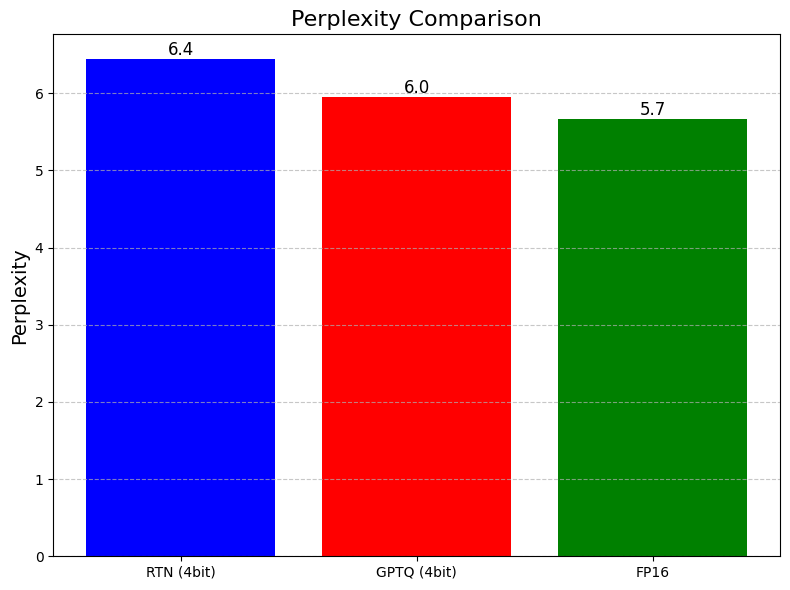

In [35]:
models = ['RTN (4bit)', 'GPTQ (4bit)', 'FP16']
perplexities = [6.44, 5.95, 5.67]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, perplexities, color=['blue', 'red', 'green'])

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{bar.get_height():.1f}',
        ha='center', va='bottom', fontsize=12
    )

plt.ylabel('Perplexity', fontsize=14)
plt.title('Perplexity Comparison', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()